In [76]:

from dotenv import load_dotenv
import os
import json
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from music21 import *
import json

# 第三方函式庫
from rich.console import Console  # 美化終端輸出
from rich.panel import Panel  # 面板顯示

# LangChain 相關
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import JsonOutputParser
from rich.progress import Progress
from rich.console import Console
from rich.panel import Panel
from rich.progress import Progress, BarColumn, TextColumn, TimeRemainingColumn
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich import box
from rich.prompt import Confirm
# Pydantic 資料驗證


env = environment.Environment()

In [90]:
# 啟用自動重新加載
%load_ext autoreload
%autoreload 2

# 直接從模組文件導入
from src.composer.style_analyzer import StyleAnalyzer
from src.composer.composition_planner import CompositionPlanner
from src.composer.instruction_generator import InstructionGenerator
from src.composer.music_theory_database import MusicTheoryDatabase
from src.composer.score_evaluator import ScoreEvaluator

# 其他導入
from src.music.agent import *
from src.music.music_player import *
from src.tool import save_to_temp, load_from_temp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
class ConductorAgent:
    STAGES = [
        "design_framework",       
        "plan_composition",       
        "generate_instructions",  
        "generate_scores",         
        "evaluate_and_revise"      
    ]
    
    def __init__(self, style: str = "classical",
                 tempo: int = 120, key: str = "C major", 
                 time_signature: str = "4/4", 
                 num_measures: int = 4,
                 musescore_path: str = "/Applications/MuseScore 4.app/Contents/MacOS/mscore",
                 api_provider: str = "gemini",  # 可選 "openai" 或 "gemini"
                 api_key: str = None,
                 temperature: float = 0.7,
                 top_p: float = 0.9):
        
        self.api_provider = api_provider
        self.api_key = api_key
        self.temperature = temperature
        self.top_p = top_p
        
        # 初始化選擇的 LLM
        if api_provider == "gemini":
            self.llm = ChatGoogleGenerativeAI(
                model="gemini-2.0-flash", 
                temperature=self.temperature, top_p=self.top_p, api_key= self.api_key)
        elif api_provider == "openai":
            if not api_key:
                
                raise ValueError("OpenAI 需要提供 API 金鑰")
            from langchain_openai import ChatOpenAI
            self.llm = ChatOpenAI(api_key=api_key, top_p=self.top_p , temperature=self.temperature)
        else:
            raise ValueError("不支援的 API 提供者，請選擇 'gemini' 或 'openai'")
        
        
        self.player = MusicPlayer(musescore_path=musescore_path)
        self.params = {
            "style": style,
            "tempo": tempo,
            "key": key,
            "time_signature": time_signature,
            "num_measures": num_measures,
            "structure": {},
            "instruments": []
        }
        
        
        self.musicians = {
            "violin": ViolinAgent("Violinist",api_provider=api_provider, api_key=api_key,),
            "viola": ViolaAgent("Violaist", api_provider=api_provider, api_key=api_key,),
            "cello": CelloAgent("Cellist", api_provider=api_provider, api_key=api_key,),
            "flute": FluteAgent("Flutist", api_provider=api_provider, api_key=api_key,),
            "clarinet": ClarinetAgent("Clarinetist", api_provider=api_provider,api_key=api_key, ),
            "trumpet": TrumpetAgent("Trumpeter", api_provider=api_provider, api_key=api_key,),
            "timpani": TimpaniAgent("Timpanist", api_provider=api_provider, api_key=api_key,),
            "paino": PianistAgent("Pianist", api_provider=api_provider, api_key=api_key,)
        }
        self.score_drafts = {}
        self.instructions = {}
        
        # 初始化輔助類
        self.style_analyzer = StyleAnalyzer(style)
        self.theory_db = MusicTheoryDatabase()
        self.composition_planner = CompositionPlanner(self.llm, self.params, self.style_analyzer, self.theory_db)
        self.instruction_generator = InstructionGenerator(self.llm, self.params, self.musicians)
        self.score_evaluator = ScoreEvaluator(self.llm)

    def add_instrument(self, instrument_type: str, role: str):
        if instrument_type not in self.musicians:
            raise ValueError(f"Unsupported instrument: {instrument_type}")
        self.params["instruments"].append(instrument_type)

    def compose(self, output_file: str = "symphony", dev_mode: bool = False, start_from: str = None) -> dict:
        console = Console()
        STAGES = ["design_framework", "plan_composition", "generate_instructions", "generate_scores", "evaluate_and_revise"]

        # 如果啟用了開發模式並指定了起始階段，嘗試加載之前的結果
        if dev_mode and start_from:
            for stage in STAGES:
                if stage == start_from:
                    break
                loaded_data = load_from_temp(stage)
                if loaded_data:
                    console.print(Panel(
                        f"已載入 [bold cyan]{stage}[/bold cyan]...",
                        border_style="green",
                        padding=(0, 1)
                    ))
                    if stage == "design_framework":
                        self.params["structure"] = loaded_data
                    elif stage == "plan_composition":
                        self.params["plan"] = loaded_data
                    elif stage == "generate_instructions":
                        self.instructions = loaded_data
                    elif stage == "generate_scores":
                        self.score_drafts = loaded_data
                else:
                    console.print(f"[red]錯誤：無法找到 {stage} 的臨時文件[/red]")
                    return {}

        # 階段 1：設計框架
        if not dev_mode or start_from == "design_framework":
            framework = self.composition_planner.design_framework()
            self.params["structure"] = framework
            if dev_mode:
                save_to_temp("design_framework", framework)  # 保存結果
            
            # 生成音樂結構，使用 Panel 展示理由
            console.print(Panel(
                f"[bold]結構選擇理由:[/bold]\n{framework['rationale']}",
                title="[bold green]🎼 生成音樂結構[/bold green]",
                border_style="yellow",
                padding=(0, 1)
            ))
        elif "structure" in self.params and dev_mode:
            console.print(Panel(
                f"載入 [bold cyan]design_framework[/bold cyan] 所以 pass 通過",
                border_style="green",
                padding=(0, 1)
            ))

        # 階段 2：作曲計畫
        if not dev_mode or start_from in ["design_framework", "plan_composition"]:
            plan = self.composition_planner.plan_composition()
            self.params["plan"] = plan
            if dev_mode:
                save_to_temp("plan_composition", plan)  # 保存結果
            
            # 使用 Table 展示作曲計畫
            table = Table(box=box.SIMPLE, border_style="yellow")
            table.add_column("項目", style="bold", justify="left")
            table.add_column("內容", justify="left")
            table.add_row("Overall Structure", plan["overall_structure"])
            table.add_row("Harmony and Dynamics", plan["harmonic_and_dynamic_plan"])
            # 內嵌子 Table 展示樂器角色
            instrument_table = Table(box=box.SIMPLE)
            instrument_table.add_column("樂器", justify="left")
            instrument_table.add_column("角色", justify="left")
            for inst, role in plan["instrument_roles"].items():
                instrument_table.add_row(inst, role)
            table.add_row("Instrument Roles", str(instrument_table))
            
            console.print(Panel(
                table,
                title="[bold green]🤔 指揮家作曲計畫[/bold green]",
                border_style="yellow",
                padding=(0, 1)
            ))
        elif "plan" in self.params and dev_mode:
            console.print(Panel(
                f"載入 [bold cyan]plan_composition[/bold cyan] 所以 pass 通過",
                border_style="green",
                padding=(0, 1)
            ))

        # 階段 3：生成聲部指令
        if not dev_mode or start_from in ["design_framework", "plan_composition", "generate_instructions"]:
            self.instructions = self.instruction_generator.generate_part_instructions()
            if dev_mode:
                save_to_temp("generate_instructions", self.instructions)  # 保存結果
            
            # 展示各聲部演奏指令
            console.print(Panel(
                "[bold blue]🎻 各聲部演奏指令[/bold blue]",
                title="[bold green]🎻 各聲部演奏指令[/bold green]",
                border_style="yellow",
                padding=(0, 1)
            ))
            # 以 Violin 為例展示一個聲部指令
            for inst, inst_instructions in self.instructions.items():
                inst_table = Table(box=box.SIMPLE)
                inst_table.add_column("類別", style="bold", justify="left")
                inst_table.add_column("內容", justify="left")
                for key, value in inst_instructions.items():
                    inst_table.add_row(key, str(value))
                console.print(Panel(
                    inst_table,
                    title=f"{inst.capitalize()}",
                    border_style="yellow",
                    padding=(0, 1)
                ))
                break  # 只展示一個作為範例
        elif self.instructions and dev_mode:
            console.print(Panel(
                f"載入 [bold cyan]generate_instructions[/bold cyan] 所以 pass 通過",
                border_style="green",
                padding=(0, 1)
            ))

        # 階段 4：生成樂譜草案
        if not dev_mode or start_from in ["design_framework", "plan_composition", "generate_instructions", "generate_scores"]:
            console.print("[bold yellow]🎼 開始生成樂譜草案...[/bold yellow]")
            
            # 使用 rich 的 Progress 來顯示進度條
            from rich.progress import Progress
            with Progress(console=console) as progress:
                task = progress.add_task("[cyan]生成樂譜中...", total=len(self.musicians))
                for inst, agent in self.musicians.items():
                    self.score_drafts[inst] = agent.generate_score(self.params, self.instructions[inst])
                    progress.update(task, advance=1)  # 每次完成一個樂器，更新進度
                
            if dev_mode:
                save_to_temp("generate_scores", self.score_drafts)  # 保存結果
            console.print(f"[bold green]✅ 所有樂譜草案生成完成！共 {len(self.musicians)} 個聲部[/bold green]")
            
            
        elif self.score_drafts and dev_mode:
            console.print(Panel(
                f"載入 [bold cyan]generate_scores[/bold cyan] 所以 pass 通過",
                border_style="green",
                padding=(0, 1)
            ))

        # # 階段 5：評估與修正
        # if not dev_mode or start_from in ["design_framework", "plan_composition", "generate_instructions", "generate_scores", "evaluate_and_revise"]:
        #     evaluation = self.score_evaluator.evaluate_score(self.score_drafts, self.musicians)
        #     attempt = 1
        #     while not evaluation["passed"]:
        #         console.print(f"[bold yellow]⚠️ 樂譜需要修正 (嘗試 {attempt})[/bold yellow]")
        #         for feedback in evaluation["feedback"]:
        #             target_inst = feedback["target"]
        #             if target_inst in self.musicians:
        #                 console.log(f"正在修正 -> {target_inst}")
        #                 self.score_drafts[target_inst] = self.musicians[target_inst].revise_score(
        #                     self.params, feedback, self.score_drafts[target_inst]
        #                 )
        #             else:
        #                 console.print(f"[yellow]忽略無效目標 '{target_inst}' 的反饋[/yellow]")
                
        #         # 先生成 MIDI 文件
        #         midi_file = f"fixup_song_{attempt}"
        #         self.player.generate_midi(self.score_drafts, midi_file)
        #         console.print(f"[bold cyan]已生成 MIDI 文件：{midi_file}.mid[/bold cyan]")
                
        #         # 詢問用戶是否繼續修正
        #         continue_fixing = Confirm.ask("請檢查生成的 MIDI 文件。你想繼續修正樂譜嗎？", default=True)
        #         if not continue_fixing:
        #             console.print("[bold green]用戶選擇停止修正，當前版本已保存。[/bold green]")
        #             break
                
        #         # 如果繼續，重新評估
        #         evaluation = self.score_evaluator.evaluate_score(self.score_drafts, self.musicians)
        #         attempt += 1
            
        #     # 最終通過或用戶停止時顯示訊息
        #     if evaluation["passed"]:
        #         console.print("[bold green]🎉 樂譜最終版本通過審核！[/bold green]")
        #     else:
        #         console.print("[yellow]修正流程已終止，未完全通過審核。[/yellow]")

        return self.score_drafts

# 測試進入點

In [88]:
STAGES = [
    "design_framework",        # 設計音樂結構
    "plan_composition",        # 生成作曲計畫
    "generate_instructions",   # 生成聲部指令
    "generate_scores",         # 生成樂譜草案
    "evaluate_and_revise"      # 評估與修正
] 
# GOOGLE_API_KEY or OPENAI_API_KEY
api_key = os.getenv("OPENAI_API_KEY")

conductor = ConductorAgent(
    style="classical",
    tempo=120,
    key="C major",
    time_signature="4/4",
    num_measures=4,
    api_provider="openai",  # 或 "openai"
    api_key=api_key,  # 若使用 OpenAI，需提供 API Key
    temperature=0.6,  # 控制旋律的創意度
    top_p=0.9,  # 控制旋律的自由度
)

# 添加樂器
conductor.add_instrument("violin", "melody")
conductor.add_instrument("viola", "harmony")
conductor.add_instrument("cello", "bass")
conductor.add_instrument("flute", "melody")
conductor.add_instrument("clarinet", "harmony")
conductor.add_instrument("trumpet", "highlight")
conductor.add_instrument("timpani", "rhythm")
# # 開始創作

score_drafts = conductor.compose(dev_mode=True, start_from="evaluate_and_revise")


# # 初始化播放器
player = MusicPlayer(musescore_path="/Applications/MuseScore 4.app/Contents/MacOS/mscore")

# 生成 MIDI
midi_path = player.generate_mp3(score_drafts, "my_song")
if midi_path:
    # 載入剛生成的 MIDI
    player.load_file(midi_path)
    # 播放
    player.play()
    # 儲存為 MusicXML
    player.save("my_song_converted", format="musicxml")

MuseScore 版本檢查成功：MuseScore4 4.5.1


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 已載入 design_framework...                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 已載入 plan_composition...                                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 已載入 generate_instructions...                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 已載入 generate_scores...                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 載入 design_framework 所以 pass 通過                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 載入 plan_composition 所以 pass 通過                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 載入 generate_instructions 所以 pass 通過                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ 載入 generate_scores 所以 pass 通過                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

MuseScore 版本檢查成功：MuseScore4 4.5.1


qt.qml.typeregistration: Invalid QML element name "IconCode"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "MusicalSymbolCodes"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "ContainerType"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "NavigationEvent"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "MUAccessible"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "CompareType"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "SelectionMode"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invalid QML element name "ToolBarItemType"; value type names should begin with a lowercase letter
qt.qml.typeregistration: Invali

MP3 檔案生成成功：my_song.mp3
載入檔案失敗：cannot find a format extensions for: /Users/hungwei/Desktop/Proj/test/SymphonyAgents/my_song.mp3


正在播放音樂 (music21)...
已儲存檔案：my_song_converted.musicxml


In [ ]:


# 定義全局參數和指令
global_params = {
    "style": "classical",
    "tempo": 120,
    "key": "C major",
    "time_signature": "4/4",
    "num_measures": 4
}

# 各種樂器的指令
instructions = {
    "violin": {
        "description": "旋律線明亮而流暢，帶有輕快的裝飾音。",
        "mood": "輕快而充滿活力"
    },
    "viola": {
        "description": "和聲線條圓潤而平穩，穩定支撐旋律。",
        "mood": "溫暖而沉穩"
    },
    "cello": {
        "description": "低沉而連貫的低音線，偶爾使用撥弦技巧來增加變化。",
        "mood": "平靜而深沉"
    },
    "flute": {
        "description": "高音旋律輕盈而流暢，充滿夢幻色彩。",
        "mood": "悠揚而靈活"
    },
    "clarinet": {
        "description": "和聲部分厚實而圓潤，帶有些許爵士感。",
        "mood": "柔和而優雅"
    },
    "trumpet": {
        "description": "亮麗而有力的高音，作為樂曲的亮點。",
        "mood": "莊嚴而強烈"
    },
    "timpani": {
        "description": "穩定而有力的節奏，給予曲子強烈的脈動感。",
        "mood": "宏大而莊嚴"
    }
}

# 建立樂譜草稿
score_drafts = {}

# 添加所有指定的樂器
instruments = [
    # ("violin", "melody"),
    # ("viola", "harmony"),
    # ("cello", "bass"),
    # ("flute", "melody"),
    # ("clarinet", "harmony"),
    # ("trumpet", "highlight"),
    ("timpani", "rhythm")
]

for inst, role in instruments:
    try:
        print(f"正在生成 {inst.capitalize()} 聲部...")
        agent_class = globals().get(f"{inst.capitalize()}Agent")
        if agent_class is None:
            print(f"警告：未找到 {inst.capitalize()}Agent 類別，跳過...")
            continue
        agent = agent_class(role=role)
        score_drafts[inst] = agent.generate_score(global_params, instructions[inst])
        print(f"{inst.capitalize()} 聲部生成完成！")
    except Exception as e:
        print(f"生成 {inst.capitalize()} 聲部時發生錯誤：{str(e)}")

# 顯示各聲部樂譜
for inst, part in score_drafts.items():
    print(f"生成的 {inst.capitalize()} 聲部：")
    part.show('text')  # 以文字形式顯示（需要 music21 環境）
    part.show('midi')  # 播放 MIDI（需要配置 MIDI 播放器）

# 初始化播放器
player = MusicPlayer(musescore_path="/Applications/MuseScore 4.app/Contents/MacOS/mscore")

# 生成 MIDI
midi_path = player.generate_mp3(score_drafts, "symphony")
if midi_path:
    # 載入剛生成的 MIDI
    player.load_file(midi_path)
    # 播放
    player.play()
    # 儲存為 MusicXML
    player.save("symphony_converted", format="musicxml")


In [101]:
design_framework_data = load_from_temp("generate_scores", "_temp")

design ="""
{
    "form": "奏鳴曲式 (Sonata Form)",
    "themes": [
        "主題1 (呈示部主部主題): 節奏為短-長-短-長，音高特徵為C大調上行級進，從C-D-E-F-G，旋律充滿活力與肯定感，猶如春日陽光下的奔流。",
        "主題2 (呈示部副部主題): 節奏為平穩的四分音符，音高特徵為G大調下行琶音，從G-D-G-E-C，旋律抒情優雅，像月光灑在靜謐湖面上的倒影。"
    ],
    "harmonic_progression": [
        "呈示部 (Exposition): C大調 (I) -> G大調 (V) (以正格終止 Authentic Cadence 結束，穩固而明亮)",
        "發展部 (Development): G大調 (V) -> A小調 (vi) -> D小調 (ii) -> G大調 (V) (探索關係小調與遠調，製造和聲上的緊張與期待)",
        "再現部 (Recapitulation): C大調 (I) -> C大調 (I) (所有主題回歸主調，使用副格終止 Plagal Cadence 增添溫暖的結束感)"
    ],
    "dynamic_plan": "呈示部從中強 (mf) 開始，主部主題逐漸增強至強 (f)，副部主題則保持中弱 (mp) 的柔和。發展部力度變化劇烈，從弱 (p) 到極強 (ff)，展現衝突與高潮。再現部與呈示部力度相似，但結尾加入漸弱 (diminuendo) 和稍慢 (ritardando)，猶如音樂徐徐落幕。",
    "instrumentation_roles": {
        "violin": "擔任主要旋律線，呈現主題1的活潑與主題2的柔美，發展部中加入快速音群，宛如流星劃空。",
        "viola": "負責中聲部和聲支持，與小提琴形成對位，發展部中低沉的音色增添戲劇性。",
        "cello": "提供穩固的低音線條，與小提琴在主題1中呼應，猶如大地承載旋律的脈動。",
        "flute": "高音裝飾，與小提琴對話，主題2中帶來清新的氣息，像微風拂過。",
        "clarinet": "中音和聲填充，與長笛形成色彩對比，發展部中增添神秘感。",
        "trumpet": "在主題1結尾與發展部高潮處強調力度，猶如號角喚醒全場。",
        "timpani": "強化節奏骨架，在主題1結尾與發展部高潮處轟鳴，帶來震撼的張力。"
    },
    "rationale": "奏鳴曲式是古典音樂的瑰寶，能展現主題的對比與發展之美。主題1的活力與主題2的抒情形成鮮明對比，發展部的轉調與力度變化帶來戲劇性張力，再現部則以主調回歸帶來滿足感。樂器編配以弦樂為核心，輔以木管與銅管的色彩，既保留古典氣質，又通過生動的力度與和聲設計，讓作品如珠寶般閃耀，吸引現代聽眾。"
}
"""
console = Console()

for instrument, part in score_drafts.items():
    print(f"Music content for {instrument}:")
    for note in part.recurse().notes:
        print(note.nameWithOctave, note.quarterLength)
    print("-" * 30)


Music content for violin:
G3 1.0
A3 1.0
B3 1.0
C4 1.0
D4 1.0
E4 1.0
F4 1.0
G4 1.0
A4 0.5
G4 0.5
F4 0.5
E4 0.5
D4 1.0
C4 1.0
G3 1.0
A3 1.0
B3 1.0
C4 1.0
D4 1.0
E4 1.0
F4 1.0
G4 1.0
A4 0.5
B4 0.5
C5 0.5
D5 0.5
E5 1.0
D5 1.0
C5 1.0
B4 1.0
A4 1.0
G4 1.0
C4 2.0
G3 2.0
------------------------------
Music content for viola:
G4 1.0
A4 1.0
B4 1.0
C5 1.0
D5 0.5
E5 0.5
D5 0.5
C5 0.5
B4 1.0
A4 1.0
G4 0.5
B4 0.5
D5 0.5
G5 0.5
G5 0.5
E5 0.5
C5 0.5
G4 0.5
C5 2.0
G4 2.0
A4 1.0
B4 1.0
C5 1.0
D5 1.0
E5 0.5
F5 0.5
E5 0.5
D5 0.5
C5 1.0
B4 1.0
A4 0.5
C5 0.5
E5 0.5
A5 0.5
A5 0.5
F5 0.5
D5 0.5
A4 0.5
D5 1.0
G4 1.0
C5 1.0
G4 1.0
G4 1.0
A4 1.0
B4 1.0
C5 1.0
D5 0.5
E5 0.5
D5 0.5
C5 0.5
B4 1.0
A4 1.0
G4 0.5
B4 0.5
D5 0.5
G5 0.5
G5 0.5
E5 0.5
C5 0.5
G4 0.5
C5 2.0
G4 2.0
------------------------------
Music content for cello:
C2 1.0
G2 1.0
E2 1.0
G2 1.0
C2 4.0
G2 2.0
D3 2.0
G2 1.0
A2 1.0
B2 1.0
C3 1.0
D3 0.5
E3 0.5
F3 0.5
G3 0.5
A3 0.5
G3 0.5
F3 0.5
E3 0.5
C2 1.0
G2 1.0
E2 1.0
G2 1.0
C2 4.0
----------------------

In [ ]:
design_framework_data = load_from_temp("generate_scores", "_temp")

design ="""
{
    "form": "奏鳴曲式 (Sonata Form)",
    "themes": [
        "主題1 (呈示部主部主題): 節奏為短-長-短-長，音高特徵為C大調上行級進，從C-D-E-F-G，旋律充滿活力與肯定感，猶如春日陽光下的奔流。",
        "主題2 (呈示部副部主題): 節奏為平穩的四分音符，音高特徵為G大調下行琶音，從G-D-G-E-C，旋律抒情優雅，像月光灑在靜謐湖面上的倒影。"
    ],
    "harmonic_progression": [
        "呈示部 (Exposition): C大調 (I) -> G大調 (V) (以正格終止 Authentic Cadence 結束，穩固而明亮)",
        "發展部 (Development): G大調 (V) -> A小調 (vi) -> D小調 (ii) -> G大調 (V) (探索關係小調與遠調，製造和聲上的緊張與期待)",
        "再現部 (Recapitulation): C大調 (I) -> C大調 (I) (所有主題回歸主調，使用副格終止 Plagal Cadence 增添溫暖的結束感)"
    ],
    "dynamic_plan": "呈示部從中強 (mf) 開始，主部主題逐漸增強至強 (f)，副部主題則保持中弱 (mp) 的柔和。發展部力度變化劇烈，從弱 (p) 到極強 (ff)，展現衝突與高潮。再現部與呈示部力度相似，但結尾加入漸弱 (diminuendo) 和稍慢 (ritardando)，猶如音樂徐徐落幕。",
    "instrumentation_roles": {
        "violin": "擔任主要旋律線，呈現主題1的活潑與主題2的柔美，發展部中加入快速音群，宛如流星劃空。",
        "viola": "負責中聲部和聲支持，與小提琴形成對位，發展部中低沉的音色增添戲劇性。",
        "cello": "提供穩固的低音線條，與小提琴在主題1中呼應，猶如大地承載旋律的脈動。",
        "flute": "高音裝飾，與小提琴對話，主題2中帶來清新的氣息，像微風拂過。",
        "clarinet": "中音和聲填充，與長笛形成色彩對比，發展部中增添神秘感。",
        "trumpet": "在主題1結尾與發展部高潮處強調力度，猶如號角喚醒全場。",
        "timpani": "強化節奏骨架，在主題1結尾與發展部高潮處轟鳴，帶來震撼的張力。"
    },
    "rationale": "奏鳴曲式是古典音樂的瑰寶，能展現主題的對比與發展之美。主題1的活力與主題2的抒情形成鮮明對比，發展部的轉調與力度變化帶來戲劇性張力，再現部則以主調回歸帶來滿足感。樂器編配以弦樂為核心，輔以木管與銅管的色彩，既保留古典氣質，又通過生動的力度與和聲設計，讓作品如珠寶般閃耀，吸引現代聽眾。"
}
"""
console = Console()

for instrument, part in score_drafts.items():
    print(f"Music content for {instrument}:")
    for note in part.recurse().notes:
        print(note.nameWithOctave, note.quarterLength)
    print("-" * 30)


Music content for violin:
G3 1.0
A3 1.0
B3 1.0
C4 1.0
D4 1.0
E4 1.0
F4 1.0
G4 1.0
A4 0.5
G4 0.5
F4 0.5
E4 0.5
D4 1.0
C4 1.0
G3 1.0
A3 1.0
B3 1.0
C4 1.0
D4 1.0
E4 1.0
F4 1.0
G4 1.0
A4 0.5
B4 0.5
C5 0.5
D5 0.5
E5 1.0
D5 1.0
C5 1.0
B4 1.0
A4 1.0
G4 1.0
C4 2.0
G3 2.0
------------------------------
Music content for viola:
G4 1.0
A4 1.0
B4 1.0
C5 1.0
D5 0.5
E5 0.5
D5 0.5
C5 0.5
B4 1.0
A4 1.0
G4 0.5
B4 0.5
D5 0.5
G5 0.5
G5 0.5
E5 0.5
C5 0.5
G4 0.5
C5 2.0
G4 2.0
A4 1.0
B4 1.0
C5 1.0
D5 1.0
E5 0.5
F5 0.5
E5 0.5
D5 0.5
C5 1.0
B4 1.0
A4 0.5
C5 0.5
E5 0.5
A5 0.5
A5 0.5
F5 0.5
D5 0.5
A4 0.5
D5 1.0
G4 1.0
C5 1.0
G4 1.0
G4 1.0
A4 1.0
B4 1.0
C5 1.0
D5 0.5
E5 0.5
D5 0.5
C5 0.5
B4 1.0
A4 1.0
G4 0.5
B4 0.5
D5 0.5
G5 0.5
G5 0.5
E5 0.5
C5 0.5
G4 0.5
C5 2.0
G4 2.0
------------------------------
Music content for cello:
C2 1.0
G2 1.0
E2 1.0
G2 1.0
C2 4.0
G2 2.0
D3 2.0
G2 1.0
A2 1.0
B2 1.0
C3 1.0
D3 0.5
E3 0.5
F3 0.5
G3 0.5
A3 0.5
G3 0.5
F3 0.5
E3 0.5
C2 1.0
G2 1.0
E2 1.0
G2 1.0
C2 4.0
----------------------

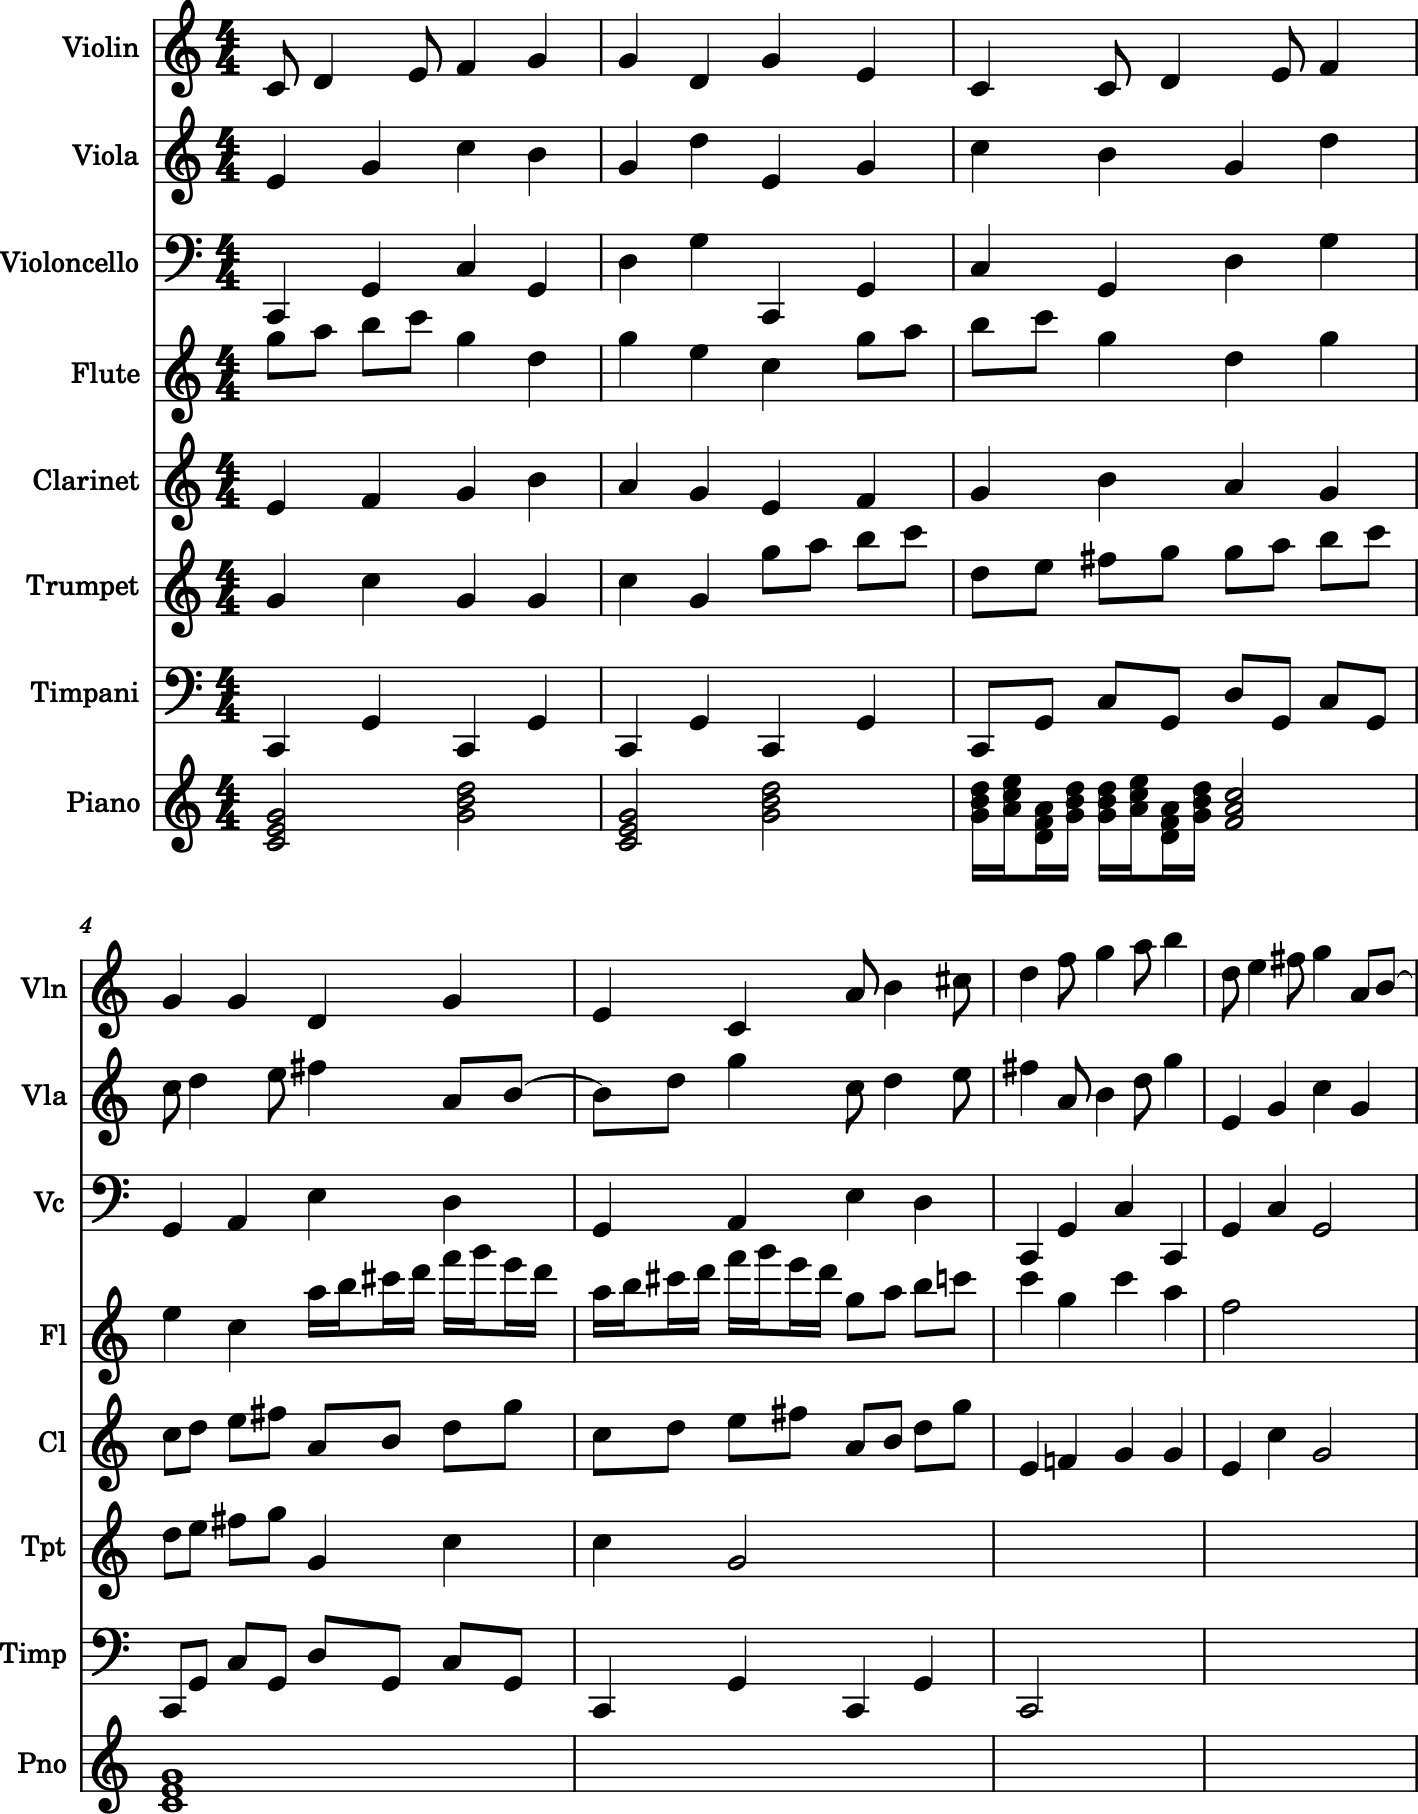

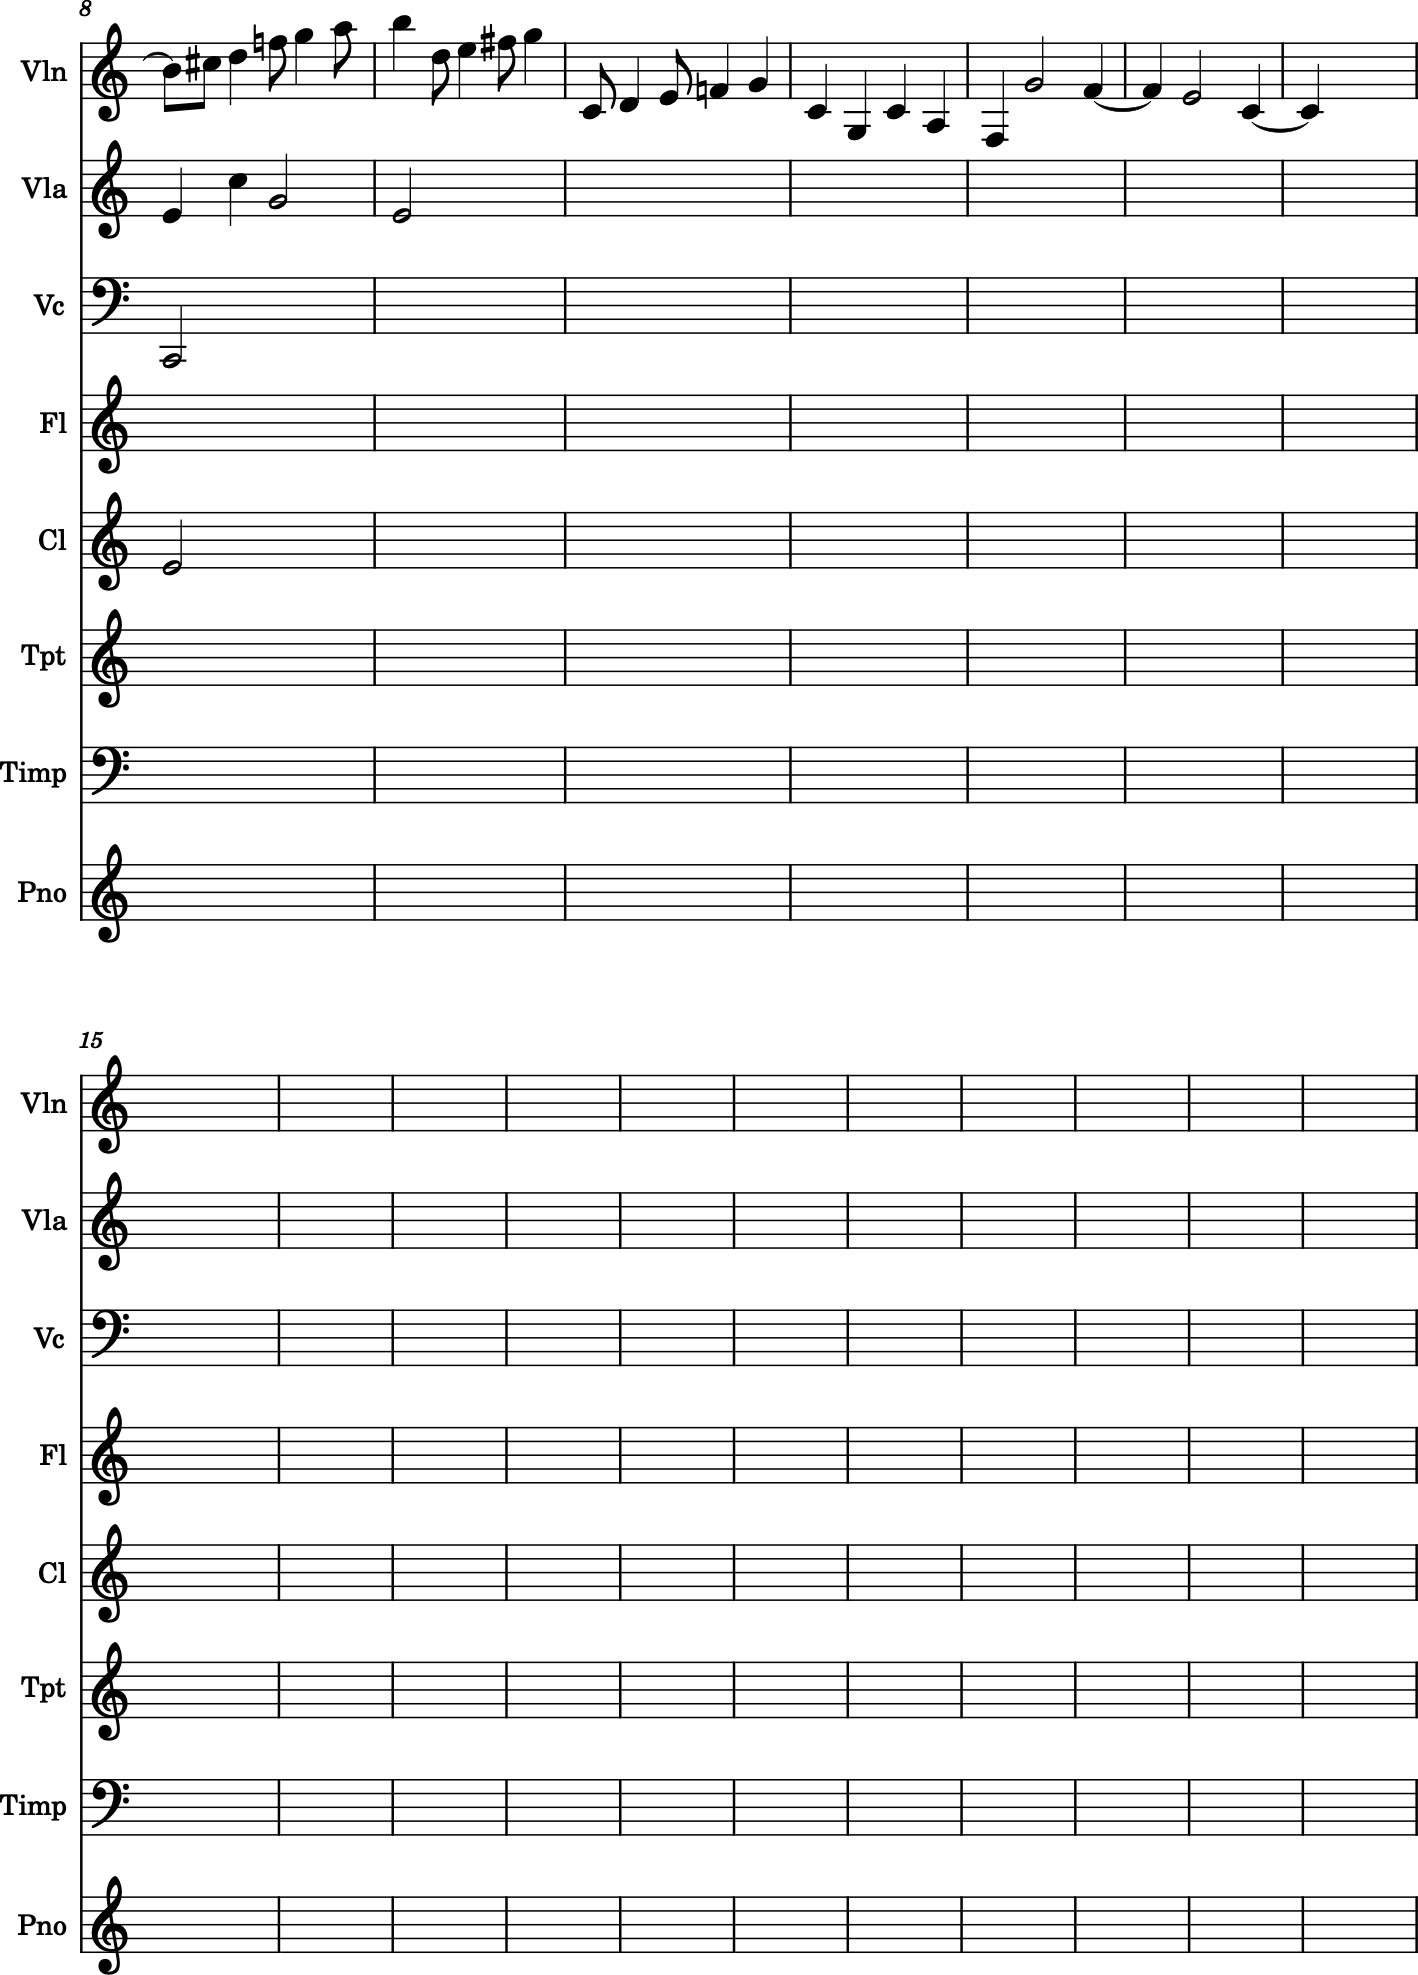

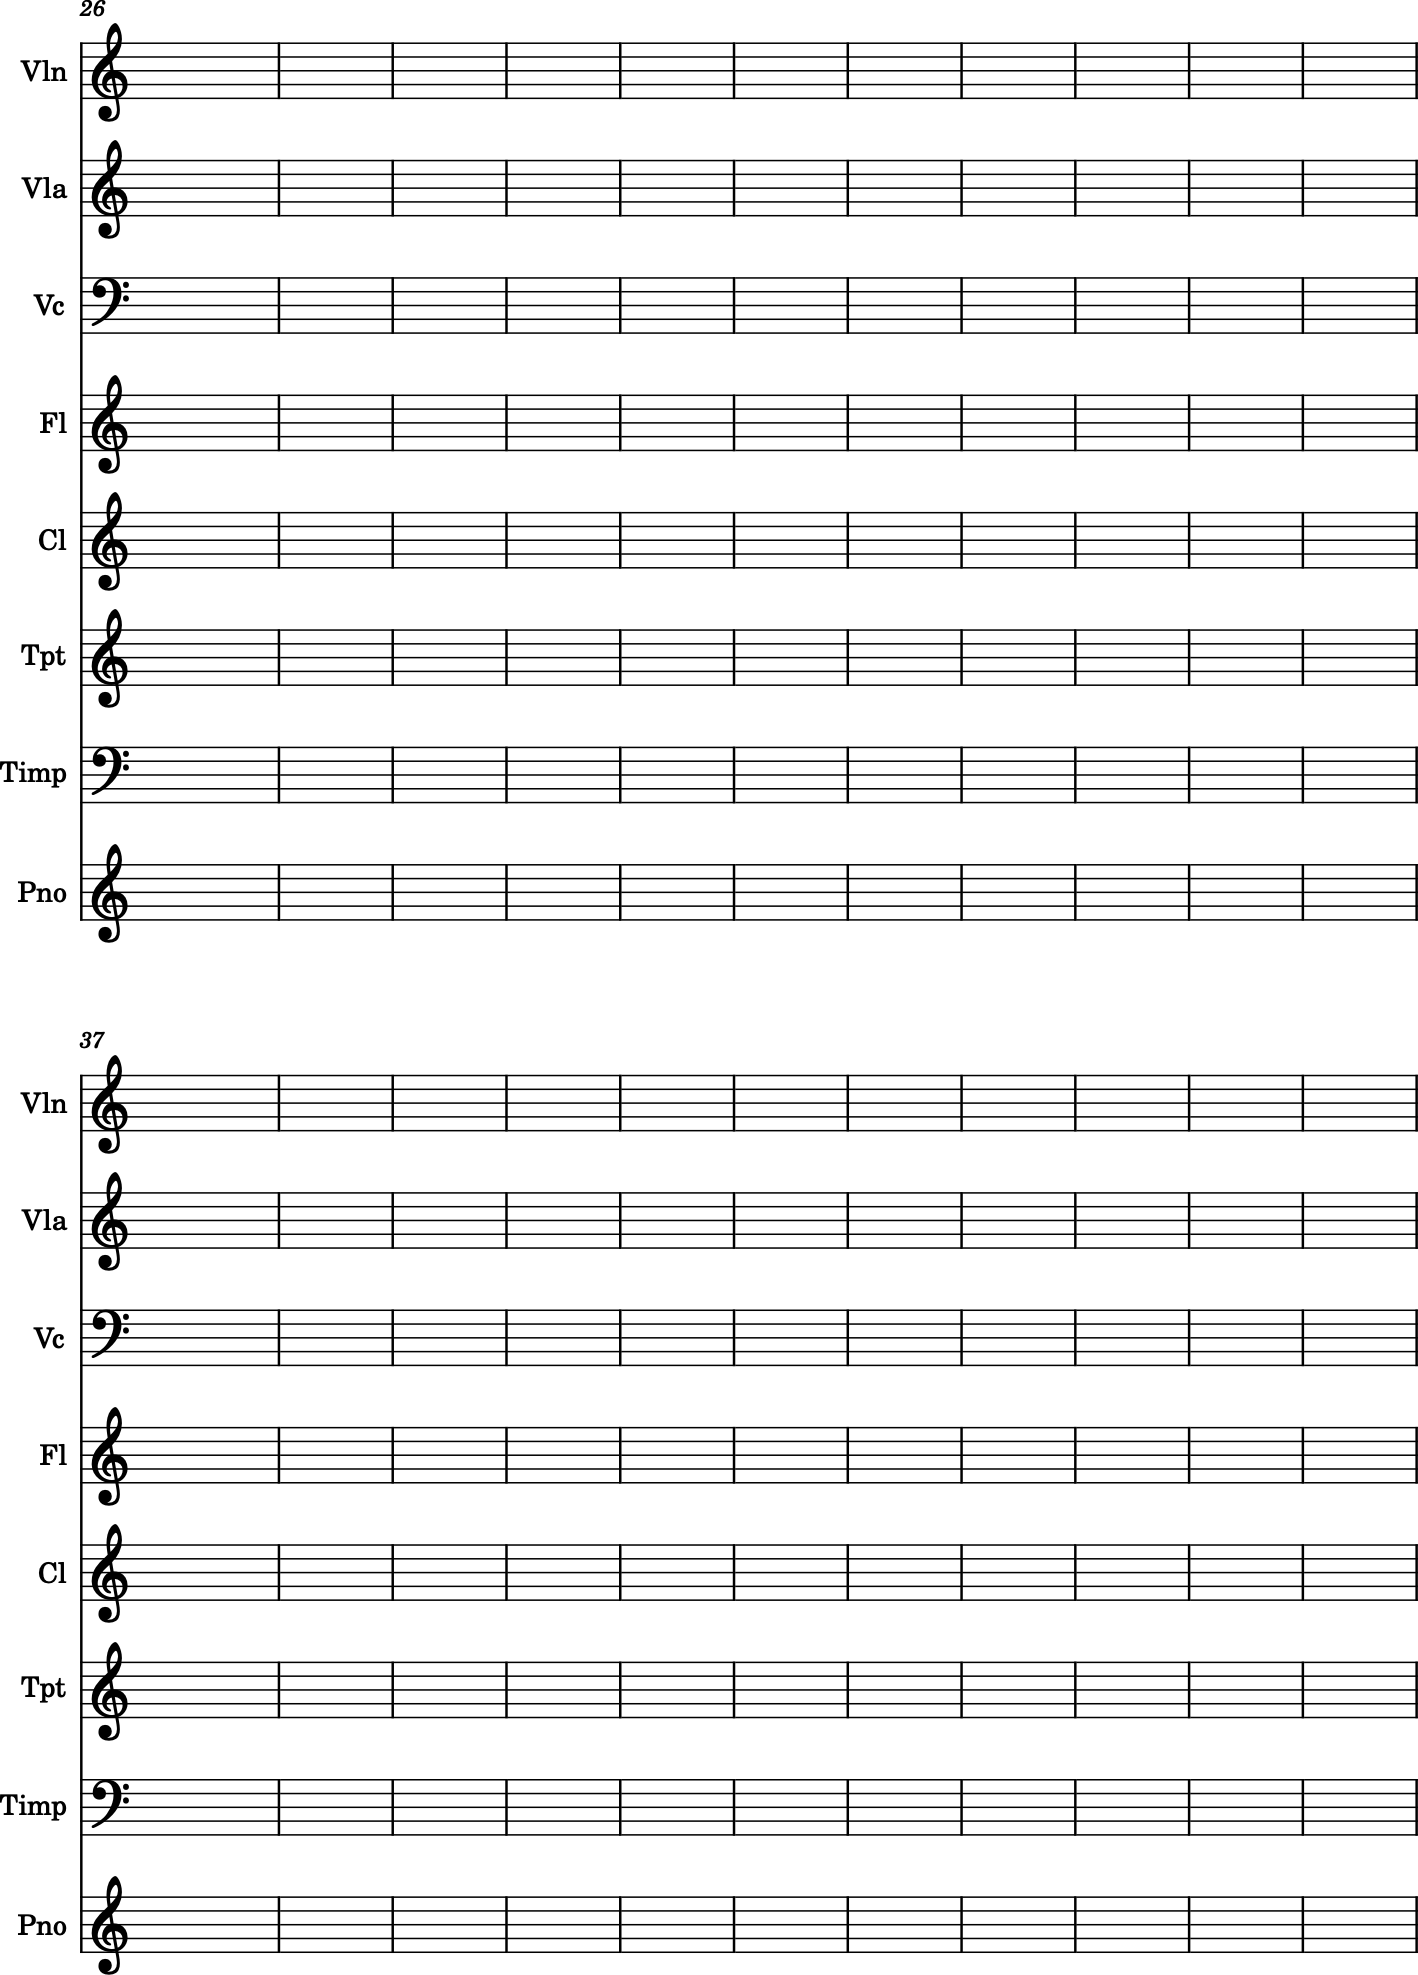

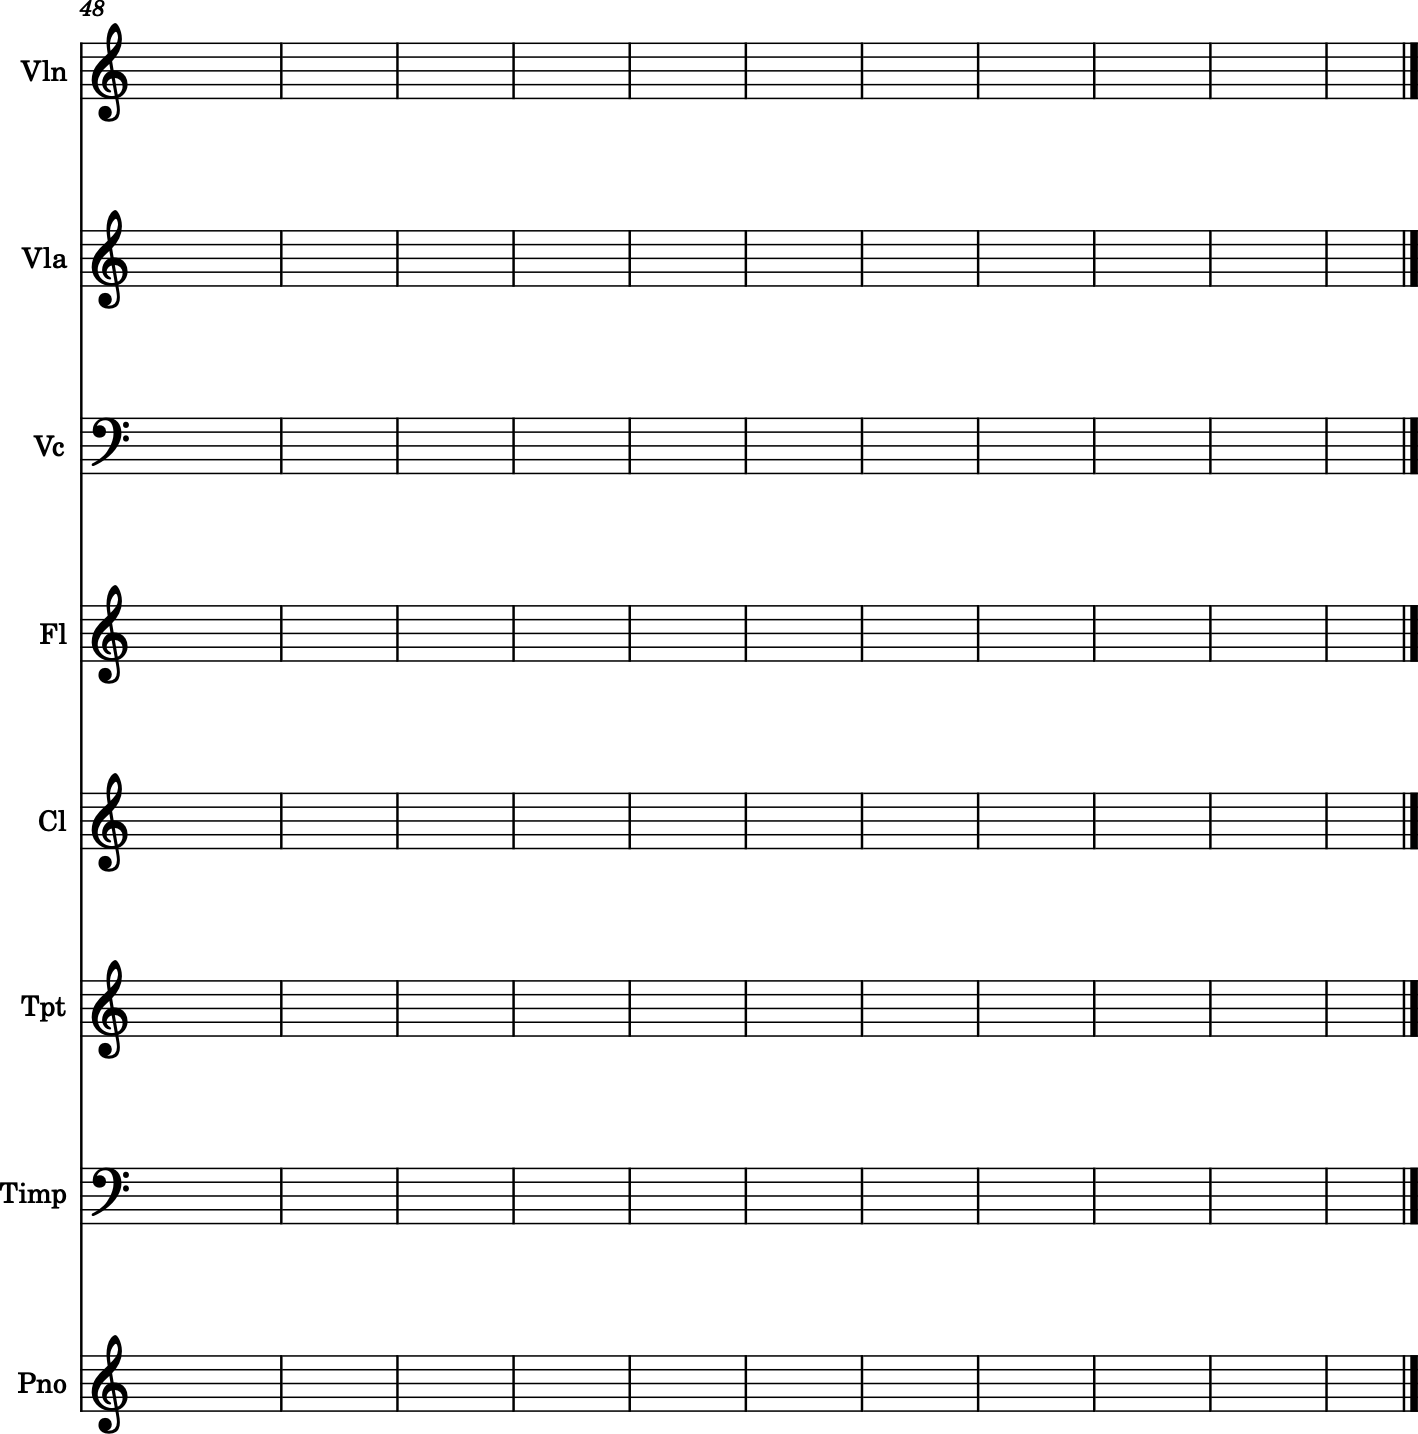

PosixPath('/Users/hungwei/Desktop/Proj/test/SymphonyAgents/symphony.xml')

In [124]:
from music21 import *

# Create instrument parts
violin = stream.Part()
violin.id = 'Violin'
violin.insert(0, instrument.Violin())

viola = stream.Part()
viola.id = 'Viola'
viola.insert(0, instrument.Viola())

cello = stream.Part()
cello.id = 'Cello'
cello.insert(0, instrument.Violoncello())

flute = stream.Part()
flute.id = 'Flute'
flute.insert(0, instrument.Flute())

clarinet = stream.Part()
clarinet.id = 'Clarinet'
clarinet.insert(0, instrument.Clarinet())

trumpet = stream.Part()
trumpet.id = 'Trumpet'
trumpet.insert(0, instrument.Trumpet())

timpani = stream.Part()
timpani.id = 'Timpani'
timpani.insert(0, instrument.Timpani())

piano = stream.Part()
piano.id = 'Piano'
piano.insert(0, instrument.Piano())

# Define Themes
# Theme 1: C major, short-long-short-long (0.5-1.0-0.5-1.0), C-D-E-F-G
theme1_notes = ['C4', 'D4', 'E4', 'F4', 'G4']
theme1_durations = [0.5, 1.0, 0.5, 1.0, 1.0]

# Theme 2: G major, steady quarter notes (1.0), G-D-G-E-C
theme2_notes = ['G4', 'D4', 'G4', 'E4', 'C4']
theme2_durations = [1.0, 1.0, 1.0, 1.0, 1.0]

# --- Exposition ---
# Violin: Theme 1 (C major) and Theme 2 (G major), repeated twice
for _ in range(2):
    for note_name, dur in zip(theme1_notes, theme1_durations):
        n = note.Note(note_name, quarterLength=dur)
        n.volume.velocity = 80  # mf, builds to f later
        violin.append(n)
    for note_name, dur in zip(theme2_notes, theme2_durations):
        n = note.Note(note_name, quarterLength=dur)
        n.volume.velocity = 60  # mp
        violin.append(n)

# Viola: Harmonic support
viola_notes = ['E4', 'G4', 'C5', 'B4', 'G4', 'D5'] * 2
viola_durations = [1.0] * 12
for note_name, dur in zip(viola_notes, viola_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 70
    viola.append(n)

# Cello: Bass line
cello_notes = ['C2', 'G2', 'C3', 'G2', 'D3', 'G3'] * 2
cello_durations = [1.0] * 12
for note_name, dur in zip(cello_notes, cello_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 80
    cello.append(n)

# Flute: High decorations
flute_notes = ['G5', 'A5', 'B5', 'C6', 'G5', 'D5', 'G5', 'E5', 'C5'] * 2
flute_durations = [0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0] * 2
for note_name, dur in zip(flute_notes, flute_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 60
    flute.append(n)

# Clarinet: Mid-range harmony
clarinet_notes = ['E4', 'F4', 'G4', 'B4', 'A4', 'G4'] * 2
clarinet_durations = [1.0] * 12
for note_name, dur in zip(clarinet_notes, clarinet_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 70
    clarinet.append(n)

# Trumpet: Emphasis at Theme 1 end
trumpet_notes = ['G4', 'C5', 'G4'] * 2
trumpet_durations = [1.0] * 6
for note_name, dur in zip(trumpet_notes, trumpet_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 90  # f
    trumpet.append(n)

# Timpani: Rhythmic foundation
timpani_notes = ['C2', 'G2', 'C2', 'G2'] * 2
timpani_durations = [1.0] * 8
for note_name, dur in zip(timpani_notes, timpani_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 80
    timpani.append(n)

# Piano: Chordal accompaniment (C -> G, authentic cadence)
piano_chords = [
    chord.Chord(['C4', 'E4', 'G4']),  # I
    chord.Chord(['G4', 'B4', 'D5']),  # V
    chord.Chord(['C4', 'E4', 'G4']),  # I
    chord.Chord(['G4', 'B4', 'D5'])   # V
]
piano_durations = [2.0, 2.0, 2.0, 2.0]
for ch, dur in zip(piano_chords, piano_durations):
    ch.quarterLength = dur
    ch.volume.velocity = 70
    piano.append(ch)

# --- Development ---
# Violin: Theme 1 fragments with key shifts
dev_notes_violin = ['A4', 'B4', 'C#5', 'D5', 'F5', 'G5', 'A5', 'B5', 'D5', 'E5', 'F#5', 'G5'] * 2
dev_durations_violin = [0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0] * 2
for i, (note_name, dur) in enumerate(zip(dev_notes_violin, dev_durations_violin)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 5  # p to ff
    violin.append(n)

# Viola: Counterpoint
dev_notes_viola = ['C5', 'D5', 'E5', 'F#5', 'A4', 'B4', 'D5', 'G5'] * 2
dev_durations_viola = [0.5, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 1.0] * 2
for i, (note_name, dur) in enumerate(zip(dev_notes_viola, dev_durations_viola)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 5
    viola.append(n)

# Cello: Walking bass
dev_notes_cello = ['G2', 'A2', 'E3', 'D3'] * 2
dev_durations_cello = [1.0] * 8
for i, (note_name, dur) in enumerate(zip(dev_notes_cello, dev_durations_cello)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 10
    cello.append(n)

# Flute: Fast note groups
dev_notes_flute = ['A5', 'B5', 'C#6', 'D6', 'F6', 'G6', 'E6', 'D6'] * 2
dev_durations_flute = [0.25] * 16
for i, (note_name, dur) in enumerate(zip(dev_notes_flute, dev_durations_flute)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 5
    flute.append(n)

# Clarinet: Mid-range counterpoint
dev_notes_clarinet = ['C5', 'D5', 'E5', 'F#5', 'A4', 'B4', 'D5', 'G5'] * 2
dev_durations_clarinet = [0.5] * 16
for i, (note_name, dur) in enumerate(zip(dev_notes_clarinet, dev_durations_clarinet)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 5
    clarinet.append(n)

# Trumpet: Climactic passages
dev_notes_trumpet = ['G5', 'A5', 'B5', 'C6', 'D5', 'E5', 'F#5', 'G5'] * 2
dev_durations_trumpet = [0.5] * 16
for i, (note_name, dur) in enumerate(zip(dev_notes_trumpet, dev_durations_trumpet)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 5
    trumpet.append(n)

# Timpani: Rolling patterns
dev_notes_timpani = ['C2', 'G2', 'C3', 'G2', 'D3', 'G2', 'C3', 'G2'] * 2
dev_durations_timpani = [0.5] * 16
for i, (note_name, dur) in enumerate(zip(dev_notes_timpani, dev_durations_timpani)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 40 + i * 5
    timpani.append(n)

# Piano: Rapid chords (G, A minor, D minor, G)
# Piano: Rapid chords (G, A minor, D minor, G), repeated
chord_progression = [
    ['G4', 'B4', 'D5'],  # G major
    ['A4', 'C5', 'E5'],  # A minor
    ['D4', 'F4', 'A4'],  # D minor
    ['G4', 'B4', 'D5']   # G major
] * 2  # This is fine, as it duplicates the list of notes, not chord objects
dev_durations_piano = [0.25] * 8

# Append chords to the piano part
for i, (chord_notes, dur) in enumerate(zip(chord_progression, dev_durations_piano)):
    ch = chord.Chord(chord_notes)  # Create a new chord object each time
    ch.quarterLength = dur
    ch.volume.velocity = 40 + i * 10
    piano.append(ch)  # No error now, as each ch is a unique object

# --- Recapitulation ---
# Violin: Theme 1 and Theme 2 in C major, plus coda
for note_name, dur in zip(theme1_notes, theme1_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 80
    violin.append(n)
theme2_recap_notes = ['C4', 'G3', 'C4', 'A3', 'F3']  # Transposed to C major
for note_name, dur in zip(theme2_recap_notes, theme2_durations):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 60
    violin.append(n)
coda_notes = ['G4', 'F4', 'E4', 'C4']
for i, note_name in enumerate(coda_notes):
    n = note.Note(note_name, quarterLength=2.0)
    n.volume.velocity = 60 - i * 10  # Diminuendo
    violin.append(n)

# Viola: Accompaniment
viola_recap_notes = ['E4', 'G4', 'C5', 'G4', 'E4', 'C5', 'G4', 'E4']
viola_recap_durations = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0]
for i, (note_name, dur) in enumerate(zip(viola_recap_notes, viola_recap_durations)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 70 - i * 5
    viola.append(n)

# Cello: Bass line
cello_recap_notes = ['C2', 'G2', 'C3', 'C2', 'G2', 'C3', 'G2', 'C2']
cello_recap_durations = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0]
for i, (note_name, dur) in enumerate(zip(cello_recap_notes, cello_recap_durations)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 80 - i * 5
    cello.append(n)

# Flute: Decorations
flute_recap_notes = ['G5', 'A5', 'B5', 'C6', 'C6', 'G5', 'C6', 'A5', 'F5']
flute_recap_durations = [0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 2.0]
for i, (note_name, dur) in enumerate(zip(flute_recap_notes, flute_recap_durations)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 60 - i * 5
    flute.append(n)

# Clarinet: Harmony
clarinet_recap_notes = ['E4', 'F4', 'G4', 'G4', 'E4', 'C5', 'G4', 'E4']
clarinet_recap_durations = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0]
for i, (note_name, dur) in enumerate(zip(clarinet_recap_notes, clarinet_recap_durations)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 70 - i * 5
    clarinet.append(n)

# Trumpet: Emphasis
trumpet_recap_notes = ['G4', 'C5', 'C5', 'G4']
trumpet_recap_durations = [1.0, 1.0, 1.0, 2.0]
for i, (note_name, dur) in enumerate(zip(trumpet_recap_notes, trumpet_recap_durations)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 90 - i * 10
    trumpet.append(n)

# Timpani: Rhythm
timpani_recap_notes = ['C2', 'G2', 'C2', 'G2', 'C2']
timpani_recap_durations = [1.0, 1.0, 1.0, 1.0, 2.0]
for i, (note_name, dur) in enumerate(zip(timpani_recap_notes, timpani_recap_durations)):
    n = note.Note(note_name, quarterLength=dur)
    n.volume.velocity = 80 - i * 10
    timpani.append(n)

# Piano: Plagal cadence (F to C)
piano_recap_chords = [chord.Chord(['F4', 'A4', 'C5']), chord.Chord(['C4', 'E4', 'G4'])]
piano_recap_durations = [2.0, 4.0]
for i, (ch, dur) in enumerate(zip(piano_recap_chords, piano_recap_durations)):
    ch.quarterLength = dur
    ch.volume.velocity = 70 - i * 20
    piano.append(ch)

# Add ritardando to the end (optional, approximated by longer note durations in coda)

# Create the score
symphony = stream.Score()
symphony.append([violin, viola, cello, flute, clarinet, trumpet, timpani, piano])

# Show the score (requires MuseScore or similar software)
symphony.show()

# Save as MIDI and MusicXML files
symphony.write('midi', 'symphony.mid')
symphony.write('musicxml', 'symphony.xml')